# Roman, Rubin SN Simulation modeling with AstroPhot

Author: Michael Wood-Vasey <wmwv@pitt.edu>  
Last Verified to run: 2023-10-06

Use the [AstroPhot](https://autostronomy.github.io/AstroPhot/) package to model lightcurve of SN in Roman HLTDS [Supernova Survey](https://ui.adsabs.harvard.edu/abs/2023MNRAS.523.3874W)
or Rubin LSST [LSST DESC DC2](https://data.lsstdesc.org/doc/dc2_sim_sky_survey) simulations.

Notable Requirements:  
astrophot  
astropy  
torch  

Major TODOs:
  * [ ] Get reasonable PSF model for image
  * [ ] Get calibrated zeropoints and make sure they're correct for the given PSF (i.e., aperture corrections).
  * [ ] Implement SIP WCS in AstroPhot to deal with slight variation in object positions
  * [ ] Update to v0.13 AstroPhot constraints.

## Data

This tutorial presents two options for datasets: "DC2" and "RomanSN".  The datasets were chosen because they were of interest to the primary author (MWV).  Unfortunately, there's just a bit of work to download the data.  For the Roman SN simulations, the extra work is that you need to download the full image focal planes, even when we're just using one detector from each (out of 18 total).  For the Rubin LSST DESC DC2 simulations, the extra work is using either Globus to download the data from the [DESC Data Archive](https://data.lsstdesc.org/doc/download), or using the [Rubin Science Pipelines DP0.2](https://data.lsst.cloud) to download the data through the Portal or API interfaces.

In [1]:
# Select `DATASET` as either "DC2" or "RomanSN"
DATASET = "DC2"
# DATASET = "RomanSN"

### LSST DESC Data Challenge 2 Data

The first data set use data from the LSST DESC DC2 simulated data set as processed by the LSST Science Pipelines for Data Preview 0.2.

https://arxiv.org/abs/2101.04855
https://ui.adsabs.harvard.edu/abs/2021ApJS..253...31L.


Option 1: Access to the DESC DC2 through the [DESC Data Archive](https://data.lsstdesc.org/doc/download) requires creating a Globus account and having a Globus end point whereever you want to put the data.  Then GUI selection of the datasets you want to download.

Option 2: Access to the Rubin-processed DP0.2 data requires [registering to be a DP0 Delegate](https://dp0-2.lsst.io/dp0-delegate-resources/index.html#) and being an LSST Data Rights Holder.

This tutorial was written using data that were downloaded thorugh the https://data.lsst.cloud Portal as r-band images overlapping the position of a supernova simulated in the DC2 data: ICRS (RA, Dec): (60.2901401, -44.142051) degrees.

This tutorials assumes that the DC2 image files will be placed into:
DATADIR = "data/DC2"

### Roman HLTDS Data

The other data set uses data from Roman simulations of SN in 
"A synthetic Roman Space Telescope High-Latitude Time-Domain Survey: supernovae in the deep field"
Wang et al. 2023, MNRAS, 523, 3, 3874.
https://ui.adsabs.harvard.edu/abs/2023MNRAS.523.3874W

Data page
https://roman.ipac.caltech.edu/sims/SN_Survey_Image_sim.html

We're here trying out 3 images selected by Lauren Aldoroty that have a SN.  You could download them here with the following bash script: 

Note that this scripts work, but gets you much more data than we needed. The three images are 1.3 GB each, covering the 18 detectors for the Roman WFI instrument.  We only need one, but the tarballs are for the full focal plane.  The rotate_Y_truth catalog is 288 MB.  The remaining catalog files are much smaller.

```
DATADIR=data/RomanSN
mkdir -p ${DATADIR}
curl "https://roman.ipac.caltech.edu/data/sims/sn_image_sims/rotate_update_Y106_132.tar.gz" --output ${DATADIR}/rotate_update_Y106_132.tar.gz
curl "https://roman.ipac.caltech.edu/data/sims/sn_image_sims/rotate_update_Y106_174.tar.gz" --output ${DATADIR}/rotate_update_Y106_174.tar.gz
curl "https://roman.ipac.caltech.edu/data/sims/sn_image_sims/rotate_update_Y106_175.tar.gz" --output ${DATADIR}/rotate_update_Y106_175.tar.gz

# SN input catalog / SN
curl https://roman.ipac.caltech.edu/data/sims/sn_image_sims/WFIRST_AKARI_FIXED_HEAD.FITS --output ${DATADIR}/WFIRST_AKARI_FIXED_HEAD.FITS

# SN input lightcurves
curl https://roman.ipac.caltech.edu/data/sims/sn_image_sims/WFIRST_AKARI_FIXED_PHOT.FITS.gz --output ${DATADIR}/WFIRST_AKARI_FIXED_PHOT.FITS.gz

# SN truth
curl https://roman.ipac.caltech.edu/data/sims/sn_image_sims/rotate_Y_truth.tar.gz --output ${DATADIR}/rotate_Y_truth.tar.gz

# Image Metadata
curl https://roman.ipac.caltech.edu/data/sims/sn_image_sims/paper_rotate.fits --output ${DATADIR}/paper_rotate.fits

cd data; (for f in rotate_update_Y106_*.tar.gz; do tar xvzf $f "*_1.fits.gz"; done); gunzip *.fits.gz; cd -
```


If you like you can view the FITS files and the SN region file (see below) with
```
ds9 data/rotate_update_Y106_132_1.fits data/rotate_update_Y106_174_1.fits data/rotate_update_Y106_175_1.fits -region load all sn.reg -scale mode zscale -scale match -frame lock wcs -zoom to fit
```

In [2]:
import os
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import iqr

import torch

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy.wcs import WCS

import astrophot as ap
from astrophot.image.window_object import Window

### SN and Host position

In [3]:
if DATASET == "DC2":
    # DC2
    sn = {"ra": 60.2901401, "dec": -44.142051}
    host = {"ra": 60.288242, "dec": -44.139890}
    npix = 100  # window will be a npix x npix box 
elif DATASET == "RomanSN":
    # RomanSN
    sn = {"ra": 71.30192566051916, "dec": -53.60051728973533}
    # We don't have a separate galaxy position here
    host = sn
    npix = 50  # window will be a npix x npix box

In [4]:
sn_coord = SkyCoord(sn["ra"], sn["dec"], unit=u.degree)

### Data files

In [5]:
if DATASET == "DC2":
    data_dir = "data/DC2"
    band = "r"

    image_file_basenames = [
        "image_calexp-r-909835-R30_S01-2025-08-18T07.fits",
        "image_calexp-r-909869-R31_S10-2025-08-18T08.fits",
        "image_calexp-r-909956-R01_S02-2025-08-18T09.fits",
        "image_calexp-r-910001-R12_S10-2025-08-18T09.fits",
        "image_calexp-r-942690-R02_S11-2025-10-12T08.fits",
        "image_calexp-r-942722-R23_S10-2025-10-12T08.fits",
        "image_calexp-r-943370-R24_S12-2025-10-13T06.fits",
        "image_calexp-r-943372-R22_S00-2025-10-13T06.fits",
        "image_calexp-r-943428-R01_S22-2025-10-13T07.fits",
        "image_calexp-r-963953-R21_S02-2025-11-19T02.fits",
        "image_calexp-r-963987-R32_S20-2025-11-19T02.fits",
        "image_calexp-r-964110-R03_S22-2025-11-19T04.fits",
        "image_calexp-r-969979-R34_S10-2025-11-28T04.fits",
        "image_calexp-r-970022-R24_S10-2025-11-28T04.fits",
    ]
    # SN live from MJD 60930 to 61020

elif DATASET == "RomanSN":
    data_dir = "data/RomanSN"
    band = "Y106"

    # The metadata for the files is stored by row idx that is encoded in the filename
    # We'll use that later to look up the informatino for the file.
    image_info_row = [132, 174, 175]
    detectors = [1, 1, 1]
    image_file_basenames = [f"rotate_update_{band}_{idx}_{det}.fits" for idx, det in zip(image_info_row, detectors)]

else:
    print(f"Unsupported DATASET: {DATASET}")

In [6]:
image_files = [os.path.join(data_dir, bn) for bn in image_file_basenames]

### Detector, Image, and FITS file order

In [7]:
# These are 4k x 4k images
pixel_scale = {"DC2": 0.2, "RomanSN": 0.11}  # "/pixel
fwhm = {"DC2": 0.6, "RomanSN": 0.2}  # "

# The HDU order is different between the two datasets
HDU_IDX = {
    "DC2": {"image": 1, "mask": 2, "variance": 3},
    "RomanSN": {"image": 1, "mask": 3, "variance": 2},
}
# as are the FITS extension names
HDU_NAMES = {
    "DC2": {"image": "image", "mask": "mask", "variance": "variance"},
    "RomanSN": {"image": "SCI", "mask": "DQ", "variance": "ERR"},
}
# so we have to use a translation regardless.

In [8]:
### Bad pixel mask values
bad_pixel_bitmask = {}

## DC2
# Pixel mask values are defined in
# https://github.com/lsst/afw/blob/29afe694f19d80cba34b10ffd361dc6ca8d49dd1/src/image/detail/MaskDict.cc#L206
# The "right" way is to use `getMaskPlaneDict` in the LSST Science Pipelines
# but we don't want to introduce that dependency here.

# "EDGE": 4 is not necessarily bad, although it could be a cause for concern we'll accept it for now
# "DETECTED": 5 and "DETECTED_NEGATIVE": 6 are both bits indicating detection of objects
# and are not "bad"
basic_mask_plane_bits = {
    "BAD": 0,
    "SAT": 1,
    "INTRP": 2,
    "CR": 3,
    "SUSPECT": 7,
    "NO_DATA": 8,
}
bad_pixel_bitmask["DC2"] = sum(
    2 ** np.array([v for v in basic_mask_plane_bits.values()])
)

## Roman
bad_pixel_bitmask["RomanSN"] = 0b1

### Lightcurve table

If you have the information, create a lightcurve table here called `lightcurve`.  It will be used below to fill in the results from the photometry.  The table should have rows in the same order as the `image_file_basenames` (and `image_files`) arrays

#### DC2
For DC2, the DATE-START, DATE-END, and DATA-AVG are stored in the header.  So we get the MJD by reading the headers and translate DATE-AVG to MJD

#### RomanSN
For Roman SN simulation, the dates are stored in a separate file: `paper_rotate.fits`.  We look up the MJD from appropriate row using the index in the simulated filename.

In [9]:
if DATASET == "DC2":
    mjd = []
    for f in image_files:
        header = fits.getheader(f)
        dt = Time(header["DATE-AVG"], scale=header["TIMESYS"].lower())
        mjd.append(dt.mjd)

elif DATASET == "RomanSN":
    image_metadata_basename = "paper_rotate.fits"
    image_metadata_filename = os.path.join(data_dir, image_metadata_basename)
    image_metadata = Table.read(image_metadata_filename)

    mjd = image_metadata[image_info_row]["date"]

In [10]:
lightcurve = Table({"image_filename": image_file_basenames, "mjd": mjd})

#### Make a convenient region file of the SN coordinates

In [11]:
# Write out RA, Dec to prepare for making a ds9 region file.
def write_ds9_region_file(
    coordinate_table, region_filename="ds9.reg", ra_colname="RA", dec_colname="DEC"
):
    region_filename = "sn.reg"
    with open(region_filename, "w") as f:
        f.write("wcs; icrs;\n")
        for r, d in coordinate_table[[ra_colname, dec_colname]]:
            f.write(f"point({r},{d});\n")

In [12]:
if DATASET == "RomanSN":
    sn_metadata_basename = "WFIRST_AKARI_FIXED_HEAD.FITS"
    sn_metadata_filename = os.path.join(data_dir, sn_metadata_basename)
    sn_metadata = Table.read(sn_metadata_filename)

    overwrite = False
    if overwrite:
        write_ds9_region_file(coordinate_table=sn_metadata, region_filename="sn.reg")

### General SN+host fitting

The rest of this Notebook should work in general for any data set (`image_files`), SN coordinates (`sn`), host coordinates (`host`), and lightcurve seeded with a column for MJD (`lightcurve`) set up above.

In [13]:
DEFAULT_ZP = 22.5  # Appropriate if the image was calibrated and scaled to nanomaggies


def make_target(
    image_filepath,
    coord: Optional[SkyCoord] = None,
    fwhm: float = fwhm[DATASET],
    psf_size: int = 51,
    pixel_scale: float = pixel_scale[DATASET],
    zeropoint: Optional[float] = None,
    hdu_idx: dict = HDU_IDX[DATASET],
    bad_pixel_bitmask: Optional[int] = bad_pixel_bitmask[DATASET],
    do_mask = False,
):
    """Make an AstroPhot target.

    image_filepath: str, Filepath to image file.
        Image file assumed to have [image, mask, variance].
        WCS assumed to be present in image HDU header

    coord: SkyCoord object with center of window
    fwhm: float, Full-Width at Half-Maximum in arcsec
    psf_size: float, width of the PSF
    pixel_scale: float, "/pix
       This is used along with fwhm, psf_size to set a Gaussian PSF model
       Would be better to have an actual PSF model from the image
    pixel_shape: (int, int), pix
    zeropoint: float, calibration of counts in image.
    """
    hdu = fits.open(image_filepath)
    header = hdu[0].header  # Primary header
    img = hdu[hdu_idx["image"]].data  # Image HDU
    var = hdu[hdu_idx["variance"]].data  # Variance HDU

    if do_mask:
        # But need to translate the informative mask with a bad-pixel mask.
        # E.g., for an LSST Science Pipelines mask, one of the mask values 
        # is that that pixel is part of a footprint of a valid object
        # We don't want to mask those!
        informative_mask = hdu[hdu_idx["mask"]].data  # Mask
        bad_pixel_mask = informative_mask & bad_pixel_bitmask

    # LSST Science PIpelines processed data will store a zeropoint in MAGZERO
    if zeropoint is None:
        try:
            zeropoint = header["MAGZERO"] + 2.5 * np.log10(header["EXPTIME"])
        except:
            zeropoint = DEFAULT_ZP

    # we construct a basic gaussian psf for each image
    # by giving the simga (arcsec), image width (pixels), and pixelscale (arcsec/pixel)
    sigma_to_fwhm = 2.355
    psf = ap.utils.initialize.gaussian_psf(fwhm / sigma_to_fwhm, psf_size, pixel_scale)
    wcs = WCS(hdu[hdu_idx["image"]].header)

    target_kwargs = {
        "data": np.array(img, dtype=np.float64),
        "variance": var,
        "zeropoint": zeropoint,
        "psf": psf,
        "wcs": wcs,
    }

    if do_mask:
        target_kwargs["mask"] = bad_pixel_mask
    if coord is not None:
        target_kwargs["reference_radec"] = (coord.ra.degree, coord.dec.degree)

    target = ap.image.Target_Image(**target_kwargs)

    return target

In [14]:
targets = [make_target(f, coord=sn_coord) for f in image_files]

Astropy WCS not tangent plane coordinate system! May not be compatable with AstroPhot.
Astropy WCS not tangent plane coordinate system! May not be compatable with AstroPhot.
Astropy WCS not tangent plane coordinate system! May not be compatable with AstroPhot.
Astropy WCS not tangent plane coordinate system! May not be compatable with AstroPhot.
Astropy WCS not tangent plane coordinate system! May not be compatable with AstroPhot.
Astropy WCS not tangent plane coordinate system! May not be compatable with AstroPhot.
Astropy WCS not tangent plane coordinate system! May not be compatable with AstroPhot.
Astropy WCS not tangent plane coordinate system! May not be compatable with AstroPhot.
Astropy WCS not tangent plane coordinate system! May not be compatable with AstroPhot.
Astropy WCS not tangent plane coordinate system! May not be compatable with AstroPhot.
Astropy WCS not tangent plane coordinate system! May not be compatable with AstroPhot.
Astropy WCS not tangent plane coordinate sy

Plot just the area of interest

In [15]:
def make_window_for_target(target, ra, dec, npix=npix):
    window = target.window.copy()
    center_xy = window.world_to_pixel(ra, dec)

    xmin = center_xy[0] - npix // 2
    xmax = center_xy[0] + npix // 2
    ymin = center_xy[1] - npix // 2
    ymax = center_xy[1] + npix // 2

    window.crop_to_pixel([[xmin, xmax], [ymin, ymax]])
    return window

def make_windows_for_targets(targets, ra, dec, npix=npix):
    windows = [make_window_for_target(t, ra, dec) for t in targets]
    return windows

In [16]:
windows = make_windows_for_targets(targets, sn["ra"], sn["dec"])

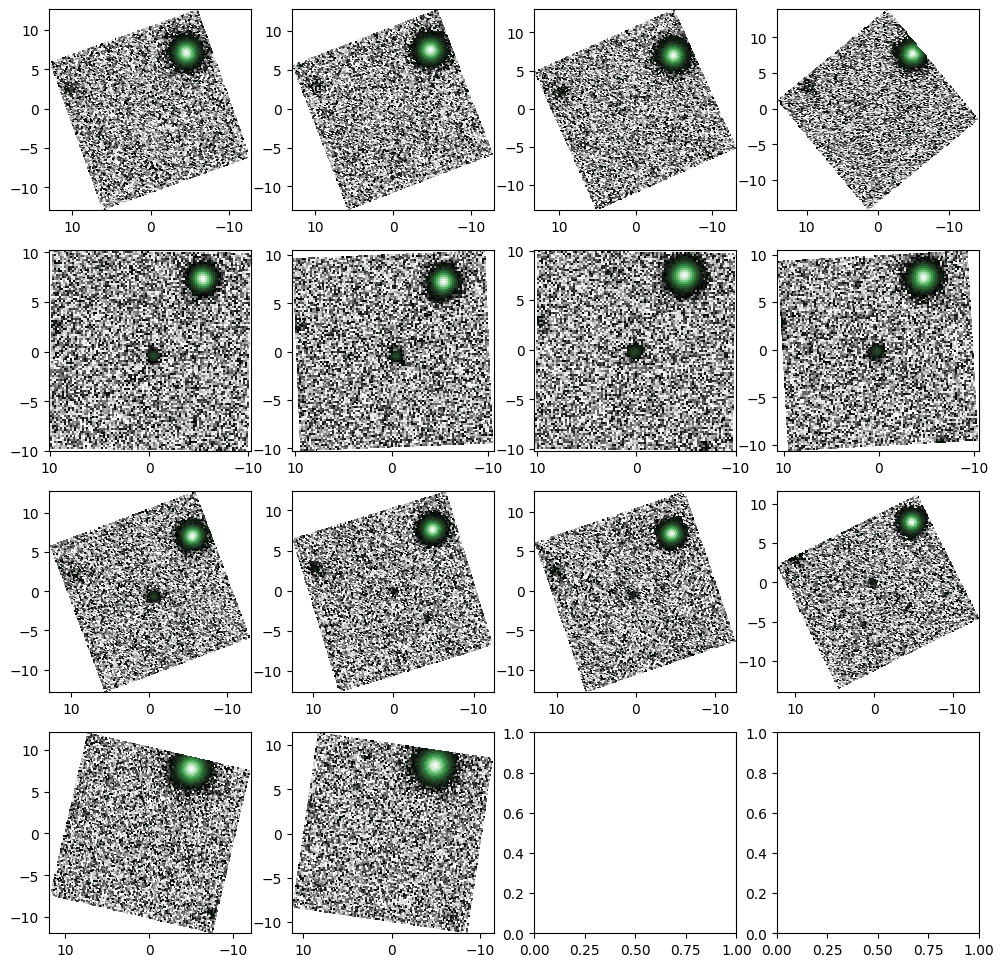

In [17]:
n = len(targets)
side = int(np.sqrt(n)) + 1
fig, ax = plt.subplots(side, side, figsize=(3 * side, 3 * side))

for i in range(n):
    ap.plots.target_image(fig, ax.ravel()[i], targets[i], window=windows[i], flipx=True)

plt.show()

The coordinate axes are in arcseconds, but in the local relative coordinate system for each image.  AstroPhot used the pixel scale to translate pixels -> arcsec.

Translate SN and host positions to projection plane positions for target.  By construction of our targets, this is in the same projection plane position.

In [18]:
sn_xy = targets[0].world_to_plane(sn["ra"], sn["dec"])
host_xy = targets[0].world_to_plane(host["ra"], host["dec"])

### Plotting Convenience Function

In [19]:
# We divide up because "model_image" expects a single axis object if single image
# while it wants an array of axis objects if there are multiple images in the image list
# model_image will not accept a one-element array if there is no image_list
def plot_target_model(model, **kwargs):
    if hasattr(model.target, "image_list"):
        _plot_target_model_multiple(model, **kwargs)
    else:
        _plot_target_model_single(model, **kwargs)


def _plot_target_model_multiple(model, window=None, titles=None, base_figsize=(12, 4), figsize=None):
    n = len(model.target.image_list)
    if figsize is None:
        figsize = (base_figsize[0], n*base_figsize[1])
    fig, ax = plt.subplots(n, 3, figsize=figsize)
    ap.plots.target_image(fig, ax[:, 0], model.target, window=window, flipx=True)
    if titles is not None:
        for i, title in enumerate(titles):
            ax[i, 0].set_title(title)
    ap.plots.model_image(fig, ax[:, 1], model, window=window, flipx=True)
    ax[0, 1].set_title("Model")
    ap.plots.residual_image(fig, ax[:, 2], model, window=window, flipx=True)
    ax[0, 2].set_title("Residual")
    plt.show()


def _plot_target_model_single(model, window=None, title=None, figsize=(16, 4)):
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    ap.plots.target_image(fig, ax[0], model.target, window=window, flipx=True)
    ax[0].set_title(title)
    ap.plots.model_image(fig, ax[1], model, window=window, flipx=True)
    ax[1].set_title("Model")
    ap.plots.residual_image(fig, ax[2], model, window=window, flipx=True)
    ax[2].set_title("Residual")
    plt.show()

### Jointly fit model across images

In [20]:
model_sky = []
model_host = []
model_sn = []

# The DC2 images are calibrated exposures that have the sky subtracted
# The RomanSN images are "raw" science images with sky.
FIT_SKY = {"DC2": False, "RomanSN": True}
FIT_HOST = True
FIT_SN = True

if FIT_SKY[DATASET]:
    for i, (target, window) in enumerate(zip(targets, windows)):
        model_sky.append(
            ap.models.AstroPhot_Model(
                name=f"sky model {i}",
                model_type="flat sky model",
                target=target,
                window=window,
            )
        )
    
if FIT_HOST:
    for i, (target, window) in enumerate(zip(targets, windows)):
        model_host.append(
            ap.models.AstroPhot_Model(
                name=f"host model {i}",
                model_type="sersic galaxy model",
                target=target,
                psf_mode="full",
                parameters={"center": host_xy},
                window=window,
            )
        )

if FIT_SN:
    for i, (target, window) in enumerate(zip(targets, windows)):
        model_sn.append(
            ap.models.AstroPhot_Model(
                name=f"SN model {i}",
                model_type="psf star model",
                psf=target.psf,
                target=target,
                psf_mode="none",
                parameters={"center": sn_xy},
                window=window,
            )
        )

In [21]:
for model in model_host[1:]:
    model.add_equality_constraint(model_host[0], ["center", "q", "PA", "n", "Re", "Ie"])

for model in model_sn[1:]:
    model.add_equality_constraint(model_sn[0], ["center"])

In [22]:
model_host_sn = ap.models.AstroPhot_Model(
    name="Host+SN",
    model_type="group model",
    models=[*model_sky, *model_host, *model_sn],
    target=ap.image.Target_Image_List(targets)
)

We have to initialize the model so that there is a value for `parameters["center"]`

In [23]:
model_host_sn.initialize()

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [24]:
result = ap.fit.LM(model_host_sn, verbose=True).fit()
print(result.message)

Chi^2: 3104.208233615304, L: 1.0
Chi^2: 3094.3407035282535, L: 8.333333333333334
Chi^2: 3006.411677344448, L: 2.777777777777778
Chi^2: 2399.9312344699924, L: 0.925925925925926
Chi^2: 853.722382806203, L: 0.308641975308642
Chi^2: 175.9985297950254, L: 0.10288065843621401
Chi^2: 52.51722128643436, L: 0.03429355281207134
Chi^2: 50.71728424194179, L: 1.4288980338363058
Chi^2: 42.57321858393846, L: 0.47629934461210194
Chi^2: 35.11725486928169, L: 0.158766448204034
Chi^2: 32.908797570237226, L: 0.05292214940134466
Chi^2: 32.53908291733128, L: 0.08820358233557445
Chi^2: 32.49724104161756, L: 0.02940119411185815
Chi^2: 32.47265801361072, L: 0.04900199018643025
Chi^2: 32.46557483087245, L: 0.08166998364405041
Could not find step to improve Chi^2, stopping
Final Chi^2: 32.46557483087245, L: 0.24500995093215125. Converged: fail. Could not find step to improve Chi^2
fail. Could not find step to improve Chi^2


In [25]:
print(model_host_sn.parameters)

Parameter Group: Host+SN
center: [-4.951914668935222, 7.447154598790082] +- [0.1, 0.1] [arcsec]
q: 0.9954590345792736 +- 0.03 [b/a, (0.0, 1.0)]
PA: 0.3711786129468731 +- 0.06 [radians, (0.0, 3.141592653589793), cyclic]
n: 1.9593454996758415 +- 0.05 [none, (0.36, 8.0)]
Re: 0.4119731818023129 +- 47.916185242050695 [arcsec, (0.0, 'None')]
Ie: 5.40992611877022 +- 0.2761358324859558 [log10(flux/arcsec^2)]
center: [0.003135071844437027, -0.19604070156811204] +- [0.1, 0.1] [arcsec]
flux: 3.689003674780494 +- 0.07460126487260603 [log10(flux/arcsec^2)]
flux: 3.774799642126354 +- 0.07457692936355233 [log10(flux/arcsec^2)]
flux: 3.487804980956323 +- 0.07457037062802857 [log10(flux/arcsec^2)]
flux: 3.136277132125956 +- 0.07451110735009224 [log10(flux/arcsec^2)]
flux: 5.1610028620902595 +- 0.07463284782544446 [log10(flux/arcsec^2)]
flux: 5.114697722573582 +- 0.07462183174298251 [log10(flux/arcsec^2)]
flux: 5.309924660698325 +- 0.07465745799646709 [log10(flux/arcsec^2)]
flux: 5.301761422080183 +- 0.

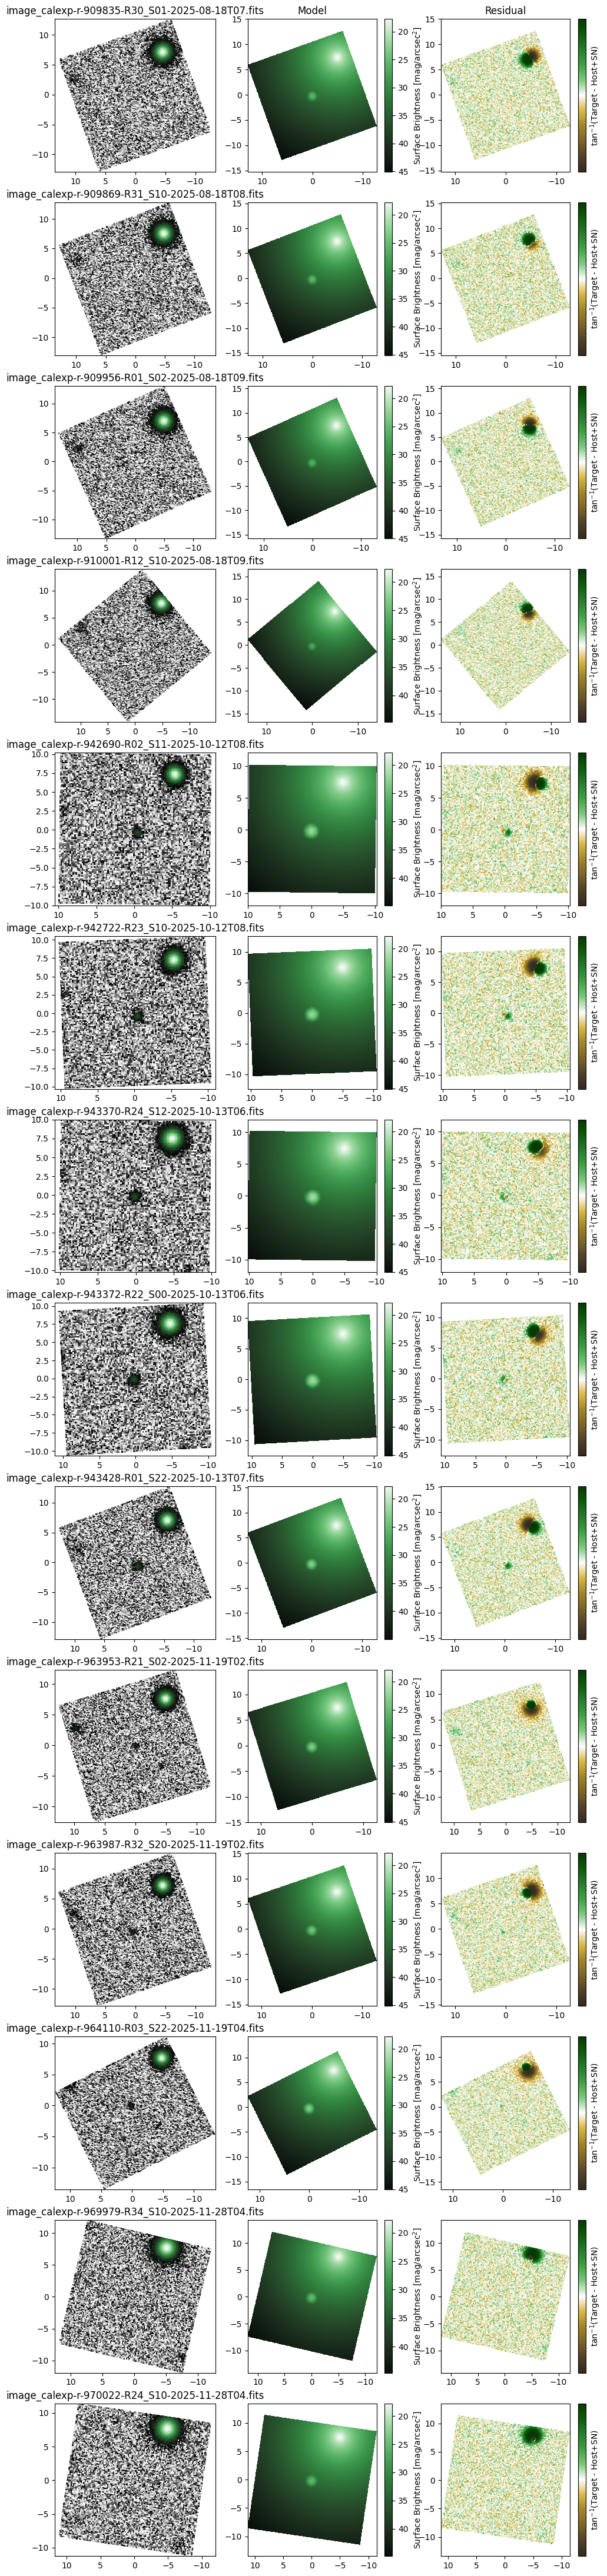

In [26]:
plot_target_model(
    model_host_sn,
    window=windows,
    titles=image_file_basenames,
)

In [27]:
sn_model_names = [f"SN model {i}" for i in range(len(targets))]

In [28]:
print(model_host_sn.models["SN model 0"].parameters)

Parameter Group: SN model 0
center: [0.003135071844437027, -0.19604070156811204] +- [0.1, 0.1] [arcsec]
flux: 3.689003674780494 +- 0.07460126487260603 [log10(flux/arcsec^2)]


In [29]:
mag = [
    -2.5 * model_host_sn.models[m].parameters.get_name("flux").value
    + model_host_sn.models[m].target.zeropoint
    for m in sn_model_names
]
mag_err = [
    2.5 * model_host_sn.models[m].parameters.get_name("flux").uncertainty
    for m in sn_model_names
]

In [30]:
lightcurve["mag"] = mag
lightcurve["mag_err"] = mag_err

In [31]:
lightcurve

image_filename,mjd,mag,mag_err
str48,float64,float64,float64
image_calexp-r-909835-R30_S01-2025-08-18T07.fits,60905.332526224534,22.94187664862322,0.18650316218151508
image_calexp-r-909869-R31_S10-2025-08-18T08.fits,60905.347876224536,22.72639860727277,0.1864423234088808
image_calexp-r-909956-R01_S02-2025-08-18T09.fits,60905.38718922338,23.445579386587745,0.18642592657007143
image_calexp-r-910001-R12_S10-2025-08-18T09.fits,60905.407900221064,24.326461455404566,0.1862777683752306
image_calexp-r-942690-R02_S11-2025-10-12T08.fits,60960.33564222222,19.271685355819308,0.18658211956361115
image_calexp-r-942722-R23_S10-2025-10-12T08.fits,60960.35065422338,19.3841450390467,0.18655457935745628
image_calexp-r-943370-R24_S12-2025-10-13T06.fits,60961.26967022107,18.89602149477684,0.1866436449911677
image_calexp-r-943372-R22_S00-2025-10-13T06.fits,60961.27057522106,18.916564335902994,0.1865968379859401
image_calexp-r-943428-R01_S22-2025-10-13T07.fits,60961.297240221065,20.232218433198476,0.1865689944451039


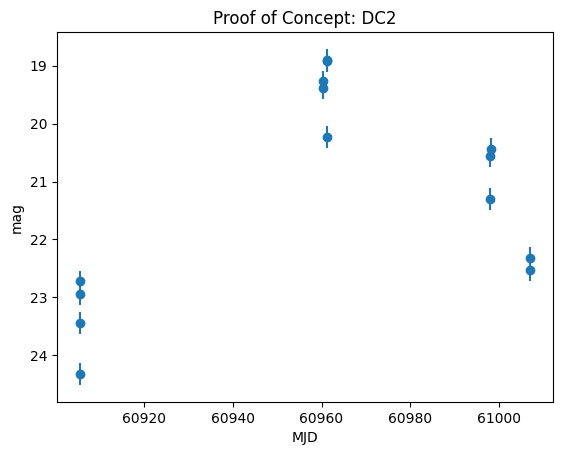

In [32]:
plt.errorbar(mjd, mag, mag_err, marker="o", linestyle="none")
plt.ylim(plt.ylim()[::-1])
plt.ylabel("mag")
plt.xlabel("MJD")
plt.title(f"Proof of Concept: {DATASET}");